In [1]:
import sys
sys.path.insert(1, '../../../../utils')
from pandas import read_csv, DataFrame
from dslabs_functions import *

from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart


In [2]:
# Load data (already split into train/test)
train_filename = "../../data/prepared/scaling/flight_train_scaling.csv"
test_filename = "../../data/prepared/scaling/flight_test_scaling.csv"

input_train_data: DataFrame = read_csv(train_filename, na_values="")
input_test_data: DataFrame = read_csv(test_filename, na_values="")

target = "Cancelled"
file_tag = "flight"
metric = "recall"
lab_folder_fs = "lab3_preparation/feature_selection"

print(input_train_data.shape, input_test_data.shape)

(140000, 141) (60000, 141)


In [3]:
# Remove FlightDate
train_data = input_train_data.drop(columns=["FlightDate"], errors="ignore")
test_data = input_test_data.drop(columns=["FlightDate"], errors="ignore")

## Study and analyze feature selection methods

### Method 1: Low variance variables

In [4]:
# Identify low-variance variables
vars2drop: list[str] = select_low_variance_variables(train_data, 0.9, target=target)
print("Variables to drop", vars2drop)

print(len(vars2drop), "variables to drop due to low variance")

# Print final variable list with for loop
final_vars = [col for col in train_data.columns if col not in vars2drop + [target]]
print("Final variables:")
for var in final_vars:
    print(var)

Variables to drop ['ArrTimeBlk_cos', 'ArrTimeBlk_sin', 'CRSArrTime', 'CRSDepTime', 'CRSElapsedTime', 'DayOfWeek', 'DayofMonth', 'DepTimeBlk_cos', 'DepTimeBlk_sin', 'Dest', 'DestCityMarketID', 'DestCityName', 'Distance', 'DistanceGroup', 'Flight_Number_Marketing_Airline', 'Flight_Number_Operating_Airline', 'Month', 'Origin', 'OriginCityMarketID', 'OriginCityName', 'Quarter', 'Tail_Number', 'Year']
23 variables to drop due to low variance
Final variables:
Airline_Air Wisconsin Airlines Corp
Airline_Alaska Airlines Inc.
Airline_Allegiant Air
Airline_American Airlines Inc.
Airline_Capital Cargo International
Airline_Comair Inc.
Airline_Commutair Aka Champlain Enterprises, Inc.
Airline_Delta Air Lines Inc.
Airline_Endeavor Air Inc.
Airline_Envoy Air
Airline_Frontier Airlines Inc.
Airline_GoJet Airlines, LLC d/b/a United Express
Airline_Hawaiian Airlines Inc.
Airline_Horizon Air
Airline_JetBlue Airways
Airline_Mesa Airlines Inc.
Airline_Republic Airlines
Airline_SkyWest Airlines Inc.
Airline

In [19]:
# sample the train and test data for faster processing
sampled_train_data = train_data.sample(n=ceil(len(train_data) * 0.1), random_state=42)
print("Sampled train data shape:", sampled_train_data.shape)
sampled_test_data = test_data.sample(n=ceil(len(test_data) * 0.1), random_state=42)
print("Sampled test data shape:", sampled_test_data.shape)

Sampled train data shape: (14000, 140)
Sampled test data shape: (6000, 140)


In [14]:
CLASS_EVAL_METRICS: dict[str, Callable] = {
    "accuracy": accuracy_score,
    "recall": recall_score,
    "precision": precision_score,
    "auc": roc_auc_score,
    "f1": f1_score,
}

DELTA_IMPROVE: float = 0.00001

def run_KNN(trnX, trnY, tstX, tstY, metric: str = "accuracy") -> dict[str, float]:
    kvalues: list[int] = [1] + [i for i in range(3, 10, 1)]
    best_model: KNeighborsClassifier = None  # type: ignore
    best_performance: float = 0
    eval: dict[str, float] = {}
    for k in kvalues:
        clf = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
        clf.fit(trnX, trnY)
        prdY: ndarray = clf.predict(tstX)
        
        try:
            if metric in ["recall", "precision", "f1"]:
                performance: float = CLASS_EVAL_METRICS[metric](tstY, prdY, average="macro")
            else:
                performance: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        except Exception:
            performance = 0.0
            
        if performance - best_performance > DELTA_IMPROVE:
            best_performance = performance
            best_model: KNeighborsClassifier = clf
    if best_model is not None:
        prd: ndarray = best_model.predict(tstX)
        for key in CLASS_EVAL_METRICS:
            eval[key] = CLASS_EVAL_METRICS[key](tstY, prd)
        eval["confusion_matrix"] = confusion_matrix(tstY, prd)
    return eval

def evaluate_approach_imported(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}
            
    eval_NB: dict[str, float] | None = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] | None = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
        
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
        eval["confusion_matrix"] = [eval_NB["confusion_matrix"], eval_KNN["confusion_matrix"]]
    return eval

def study_variance_for_feature_selection_imported(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))]
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in options:
        vars2drop: Index[str] = summary5.columns[summary5.loc["std"] * summary5.loc["std"] < thresh]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach_imported(train_copy, test_copy, target=target, metric=metric)
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} variance study ({metric})",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    return results

recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall
recall


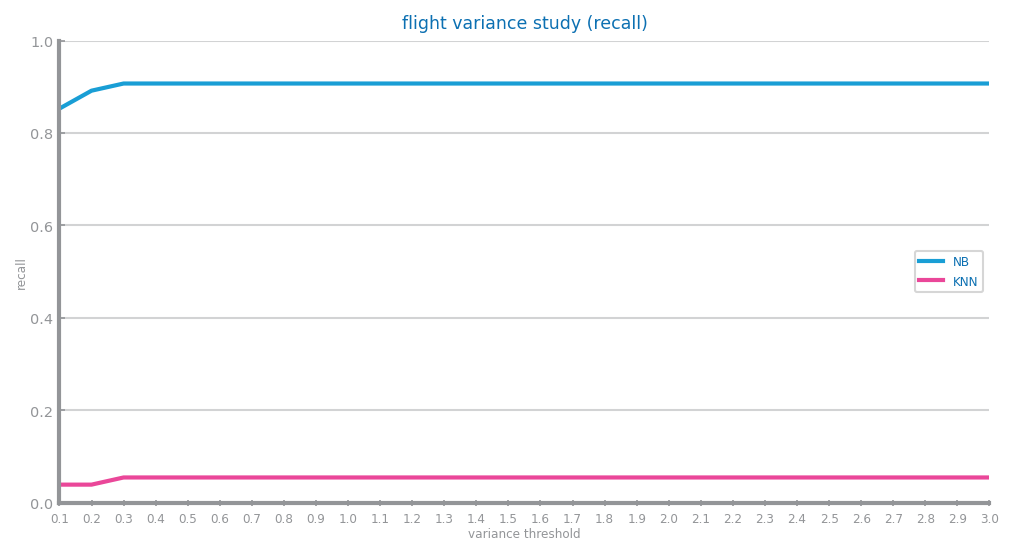

In [71]:
# Threshold analysis
figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection_imported(
    sampled_train_data,
    sampled_test_data,
    target=target,
    max_threshold=3,
    lag=0.1,
    metric=metric,
    file_tag=file_tag,
)
# savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
show()

### Method 2: Redundant variables

In [15]:
# Local copy of select_redundant_variables with fixes
def select_redundant_variables(data: DataFrame, min_threshold: float = 0.8, target: str = "class") -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True, errors='ignore')
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop

In [16]:
# Identify redundant variables
vars2drop: list[str] = select_redundant_variables(train_data, target=target, min_threshold=0.5)
print("Variables to drop", vars2drop)

print(len(vars2drop), "variables to drop due to redundancy")

# Print final variable list with for loop
final_vars = [col for col in train_data.columns if col not in vars2drop + [target]]
print("Final variables:")
for var in final_vars:
    print(var)

Variables to drop ['Marketing_Airline_Network_AS', 'Operated_or_Branded_Code_Share_Partners_AS', 'Operating_Airline_AS', 'Marketing_Airline_Network_G4', 'Operated_or_Branded_Code_Share_Partners_G4', 'Operating_Airline_G4', 'Marketing_Airline_Network_AA', 'Operated_or_Branded_Code_Share_Partners_AA', 'Operating_Airline_AA', 'Marketing_Airline_Network_DL', 'Operated_or_Branded_Code_Share_Partners_DL', 'Operating_Airline_DL', 'Operated_or_Branded_Code_Share_Partners_DL_CODESHARE', 'Operating_Airline_9E', 'Marketing_Airline_Network_F9', 'Operated_or_Branded_Code_Share_Partners_F9', 'Operating_Airline_F9', 'Marketing_Airline_Network_HA', 'Operated_or_Branded_Code_Share_Partners_HA', 'Operating_Airline_HA', 'OriginState_Non-continental US', 'Operated_or_Branded_Code_Share_Partners_AS_CODESHARE', 'Operating_Airline_QX', 'Marketing_Airline_Network_B6', 'Operated_or_Branded_Code_Share_Partners_B6', 'Operating_Airline_B6', 'Marketing_Airline_Network_WN', 'Operated_or_Branded_Code_Share_Partners_

In [25]:
def study_redundancy_for_feature_selection_imported(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [round(min_threshold + i * lag, 3) for i in range(ceil((1 - min_threshold) / lag) + 1)]

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True, errors="ignore")
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach_imported(train_copy, test_copy, target=target, metric=metric)
        if eval is not None and metric in eval:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    return results

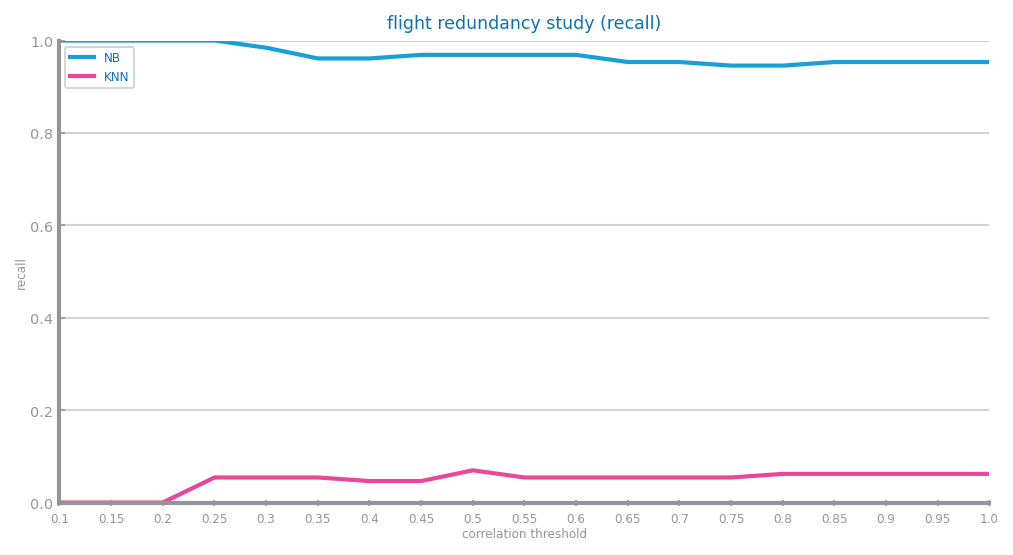

In [26]:
# Threshold analysis
figure(figsize=(2 * HEIGHT, HEIGHT))
study_redundancy_for_feature_selection_imported(
    sampled_train_data,
    sampled_test_data,
    target=target,
    min_threshold=0.1,
    lag=0.05,
    metric=metric,
    file_tag=file_tag,
)
# savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
show()

## Apply feature selection

In [27]:
# Local copy of apply_feature_selection without CSV saving
def apply_feature_selection(
    train: DataFrame,
    test: DataFrame,
    vars2drop: list,
) -> tuple[DataFrame, DataFrame]:
    train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
    test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
    return train_copy, test_copy

### Low variance selection

In [ ]:
# Save copies of train/test after removing low variance variables
vars2drop: list[str] = select_low_variance_variables(train_data, max_threshold=0.4, target=target)
train_cp, test_cp = apply_feature_selection(train_data, test_data, vars2drop)

# Re-add FlightDate
train_flightdate = input_train_data["FlightDate"]
test_flightdate  = input_test_data["FlightDate"]
train_cp["FlightDate"] = train_flightdate.values
test_cp["FlightDate"] = test_flightdate.values

output_train_path = "../../data/prepared/feature-selection/flight_train_fs_lv.csv"
output_test_path  = "../../data/prepared/feature-selection/flight_test_fs_lv.csv"

print("Saving feature selected TRAIN to:", output_train_path)
print("Saving feature selected TEST  to:", output_test_path)

train_cp.to_csv(output_train_path, index=False)
test_cp.to_csv(output_test_path,  index=False)


print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

### Redundant variable selection

In [ ]:
# Save copies of train/test after removing low variance variables
vars2drop: list[str] = select_low_variance_variables(train_data, max_threshold=0.6, target=target)
train_cp, test_cp = apply_feature_selection(train_data, test_data, vars2drop)

# Re-add FlightDate
train_flightdate = input_train_data["FlightDate"]
test_flightdate  = input_test_data["FlightDate"]
train_cp["FlightDate"] = train_flightdate.values
test_cp["FlightDate"] = test_flightdate.values

output_train_path = "../../data/prepared/feature-selection/flight_train_fs_red.csv"
output_test_path  = "../../data/prepared/feature-selection/flight_test_fs_red.csv"

print("Saving feature selected TRAIN to:", output_train_path)
print("Saving feature selected TEST  to:", output_test_path)

train_cp.to_csv(output_train_path, index=False)
test_cp.to_csv(output_test_path,  index=False)


print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

### Apply both

In [14]:
# Save copies of train/test after removing low variance variables
lv_vars2drop: list[str] = select_low_variance_variables(train_data, max_threshold=0.6, target=target)
red_vars2drop: list[str] = select_redundant_variables(train_data, min_threshold=0.5, target=target)

# Concatinate and remove duplicates
vars2drop: list[str] = list(set(lv_vars2drop + red_vars2drop))
train_cp, test_cp = apply_feature_selection(train_data, test_data, vars2drop)

# Re-add FlightDate
train_flightdate = input_train_data["FlightDate"]
test_flightdate  = input_test_data["FlightDate"]
train_cp["FlightDate"] = train_flightdate.values
test_cp["FlightDate"] = test_flightdate.values

output_train_path = "../../data/prepared/feature-selection/flight_train_fs_both.csv"
output_test_path  = "../../data/prepared/feature-selection/flight_test_fs_both.csv"

print("Saving feature selected TRAIN to:", output_train_path)
print("Saving feature selected TEST  to:", output_test_path)

train_cp.to_csv(output_train_path, index=False)
test_cp.to_csv(output_test_path,  index=False)


print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Saving feature selected TRAIN to: ../../data/prepared/feature-selection/flight_train_fs_both.csv
Saving feature selected TEST  to: ../../data/prepared/feature-selection/flight_test_fs_both.csv
Original data: train=(140000, 181), test=(60000, 181)
After low variance FS: train_cp=(140000, 45), test_cp=(60000, 45)
